In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import seaborn as sb
sb.set_style('darkgrid')

from glob import glob
import matplotlib.pyplot as plt
import os
import random
# import cv2

import gzip
import nibabel as nb

In [2]:
mri_file = glob('/Volumes/DISK_IMG/100610/m100610_T1w.nii.gz')
mri_im = nb.load(mri_file[0])
# mri_hdr = mri_im.header
mri_data = mri_im.get_fdata()

In [3]:
sos_file = glob('/Volumes/DISK_IMG/100610/Vp.nii.gz')
sos_im = nb.load(sos_file[0])
# sos_hdr = sos_im.header
sos_data = sos_im.get_fdata()

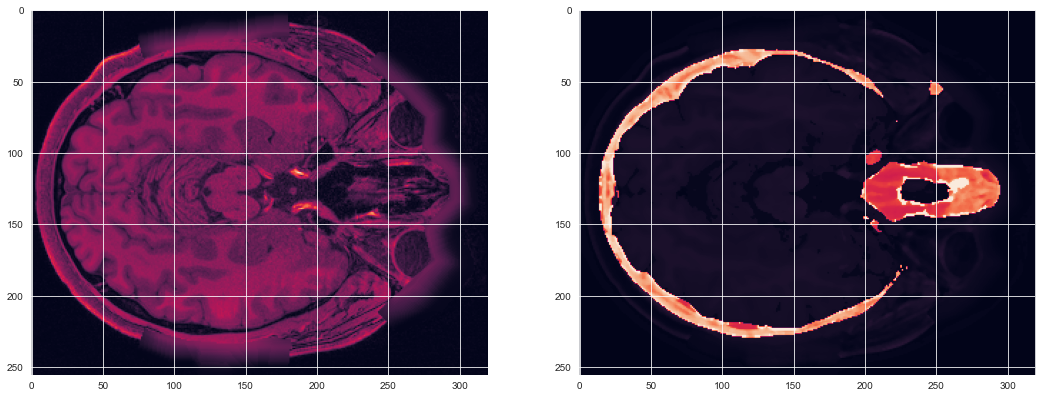

In [4]:
f = plt.subplots(1,2,figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(mri_data[:,:,120])
plt.subplot(1,2,2)
plt.imshow(sos_data[:,:,120])

In [4]:
# take just one slice
mri_slice = mri_data[:,:,120]
sos_slice = sos_data[:,:,120]
# make both image matrices into vectors
mri_slice = mri_slice.flatten()
sos_slice = sos_slice.flatten()

In [26]:
# check that the data is now just a vector
mri_slice

array([30.63180542, 19.13003159, 36.94176483, ..., 71.58135986,
       50.33592606,  0.        ])

Text(0, 0.5, 'sound speed')

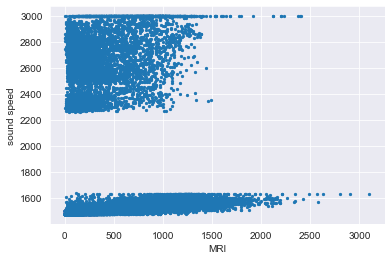

In [27]:
plt.scatter(mri_slice, sos_slice, s=5)
plt.xlabel("MRI")
plt.ylabel("sound speed")
# there doesnt seem to be any linear relation at all!!

In [29]:
# let's examine how much of the data comes from the skull
skull = []
for i in range(len(sos_slice)):
    if sos_slice[i] >= 1700:
        skull.append(i)

print(str(len(skull)) + ' out of ' + str(len(sos_slice)) + ' pixels were bone.')
print('Thats ' + str(len(skull)*100/len(sos_slice)) + ' percent.')

6635 out of 81920 pixels were bone.
Thats 8.099365234375 percent.


In [5]:
# replace any values over 1700 by 0s
soft_sos = []
soft_mri = []
for i in range(len(sos_slice)):
    if sos_slice[i] >= 1700:
        soft_sos.append(0)
        soft_mri.append(0)
    elif sos_slice[i] < 1700:
        soft_sos.append(sos_slice[i])
        soft_mri.append(mri_slice[i])

Text(0.5, 1.0, 'MRI')

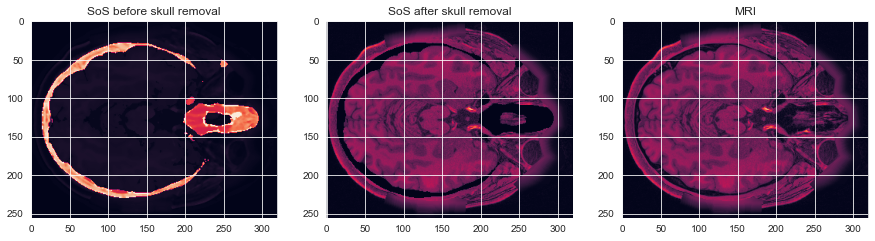

In [7]:
# just out of curiosity, let's replot the SoS graph without the skull
# first reshape the data
soft_sos_2 = soft_mri.copy()
soft_sos_2 = np.array(soft_sos_2).reshape([256, 320])
f = plt.subplots(1,3,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(sos_data[:,:,120])
plt.title('SoS before skull removal')
plt.subplot(1,3,2)
plt.imshow(soft_sos_2)
plt.title('SoS after skull removal')
plt.subplot(1,3,3)
plt.imshow(mri_data[:,:,120])
plt.title('MRI')

(1400.0, 1700.0)

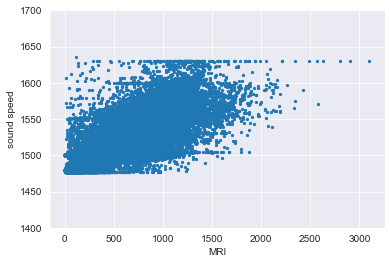

In [8]:
plt.scatter(soft_mri, soft_sos, s=5)
plt.xlabel("MRI")
plt.ylabel("sound speed")
plt.ylim(bottom=1400, top=1700)

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(soft_mri, soft_sos, test_size=0.33, random_state=42)

In [8]:
train_X = np.array(train_X).reshape(-1,1)
train_y = np.array(train_y).reshape(-1,1)
test_X = np.array(test_X).reshape(-1,1)
test_y = np.array(test_y).reshape(-1,1)

In [9]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(train_X, train_y)

LinearRegression()

In [10]:
preds = linear.predict(test_X)

In [11]:
coef = linear.coef_
intercept = linear.intercept_
print("The coefficient is " + str(coef[0][0]))
print("The intercept is " + str(intercept[0]))

The coefficient is 0.390024698586236
The intercept is 1188.76314830386


In [64]:
r2 = linear.score(test_y, preds)
r2

-3.4947878571412163

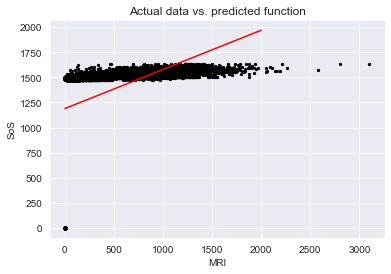

In [76]:
x = np.linspace(0,2000)
y = coef * x + intercept

plt.figure()
plt.scatter(test_X, test_y, c='black', s=5)
# plt.ylim(bottom=1400, top=1700)
plt.plot(x, y[0], '-r')
plt.title("Actual data vs. predicted function")
plt.xlabel("MRI")
plt.ylabel("SoS")
plt.show()

In [6]:
# a possible reason why the line is so wrong is cos we have a lot of 0 points... let's take them away and see what happens
soft_sos_2 = []
soft_mri_2 = []
for i in range(len(soft_sos)):
    if soft_sos == 0:
        skip
    else:
        soft_sos_2.append(soft_sos)
        soft_mri_2.append(soft_mri)

In [9]:
len(soft_sos_2)

81920

In [7]:
train_indices = []
train_X_2 = []
train_y_2 = []
for i in range(int(0.7*len(soft_sos_2))):
    # get 70% of the set for training from the whole thing randomly
    r = random.randint(0, len(soft_sos_2)) 
    train_indices.append(r)
    train_X_2.append(soft_mri_2[r])
    train_y_2.append(soft_sos_2[r])
print(len(train_X_2))
# output should be 57344

57344


In [8]:
test_X_2 = []
test_y_2 = []
for i in range(len(soft_sos_2)):
    if i not in train_indices:
        test_X_2.append(soft_mri_2[i])
        test_y_2.append(soft_sos_2[i])

In [ ]:
train_X_2 = np.array(train_X_2).reshape(-1,1)
train_y_2 = np.array(train_y_2).reshape(-1,1)
test_X_2 = np.array(test_X_2).reshape(-1,1)
test_y_2 = np.array(test_y_2).reshape(-1,1)

In [ ]:
train_X_2.shape

Error: Kernel is dead

In [24]:
train_y_2.shape

(54886, 1)

In [ ]:
from sklearn.linear_model import LinearRegression
linear_2 = LinearRegression()
linear_2.fit(train_X_2, train_y_2)
preds_2 = linear_2.predict(test_X_2)

Error: Kernel is dead

In [81]:
coef_2 = linear.coef_
intercept_2 = linear.intercept_
print("The coefficient is now " + str(coef_2[0][0]))
print("The intercept is now " + str(intercept_2[0]))
r2 = linear.score(test_y, preds)
print("The R2 score is now " + str(r2))

The coefficient is now 0.390024698586236
The intercept is now 1188.76314830386
The R2 score is now -3.4947878571412163


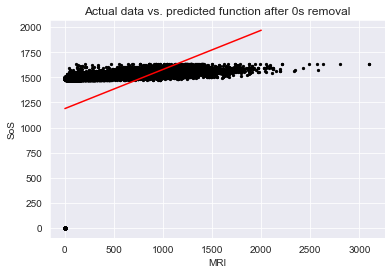

In [83]:
x_2 = np.linspace(0,2000)
y_2 = coef_2 * x + intercept_2

plt.figure()
plt.scatter(test_X_2, test_y_2, c='black', s=5)
# plt.ylim(bottom=1400, top=1700)
plt.plot(x_2, y_2[0], '-r')
plt.title("Actual data vs. predicted function after 0s removal")
plt.xlabel("MRI")
plt.ylabel("SoS")
plt.show()